<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/rdkit_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/python_package/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 模块导入


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 
from rdkit import rdBase, DataStructs
from rdkit.Chem import PandasTools
import gzip
import numpy as np
import pandas as pd

print('rdkit version: ',rdBase.rdkitVersion)
print('pandas version: ', pd.__version__)

rdkit version:  2022.09.4
pandas version:  1.5.3


## 1.常规读入分子/输出

In [ ]:
# 从sdf文件中读
spl = Chem.SDMolSupplier('/content/drive/My Drive/data/molecules.sdf') 
# 从sdf.gz压缩格式读
gz_file = gzip.open('/content/drive/My Drive/data/molecules.sdf.gz', 'r')
spl2 = Chem.ForwardSDMolSupplier(gz_file)
# 从mol2文件中读()
spl3 = Chem.MolFromMol2File('/content/drive/My Drive/data/molecule.mol2')
# 从smile中读
mol = Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
# 读取PDB
mol2 = Chem.MolFromPDBFile('/content/drive/My Drive/data/6x9i.pdb')
# FASTA
mol3 = Chem.MolFromFASTA('/content/drive/My Drive/data/protein.fasta')
# peptide
mol4 = Chem.MolFromSequence('ATTMCYP')


## 2.计算分子描述符/分子输出

In [ ]:
# 计算原子数
atomNum = mol.GetNumAtoms()
# 质子化
molH = AllChem.AddHs(mol)
# 计算TPSA
TPSA = Descriptors.TPSA(mol)
# 计算油水分配系数
logP = round(Descriptors.MolLogP(mol), 2)
# 计算电荷数
def compute_n_charge(a):
    #compute the totoal number of charge
    SMILE=str(Chem.MolToSmiles(a))
    positive_n_charge=SMILE.count('+')
    negative_n_charge=SMILE.count('-')
    total_charge=int(positive_n_charge-negative_n_charge)
    return total_charge
n_charge = compute_n_charge(mol)
# 读取分子名
#Name = mol.GetProp('_Name')

# 计算分子量
MW = round(Descriptors.MolWt(mol), 2)

print('%-10s\t%-10s\t%-10s\t%-10s\t%-10s\t' % ('原子数', 'TPSA', 'logP','带电荷数','分子量'))
print('%-10s\t%-10s\t%-10s\t%-10s\t%-10s\t' % (atomNum, TPSA, logP, n_charge, MW ))

原子数       	TPSA      	logP      	带电荷数      	分子量       	
15        	37.3      	3.07      	0         	206.28    	


In [ ]:
#文件输出
writer = Chem.SDWriter('./output.sdf')
writer.SetProps(['_Name', 'logP', 'MW', 'Charge'])
mol.SetProp('MW', '%.2f' %(MW))
mol.SetProp('logP', '%.2f' %(logP))
mol.SetProp('_Name', 'test')
mol.SetProp('Charge', '%.0f' %(n_charge))
writer.write(mol)
writer.close()

## 3.绘图

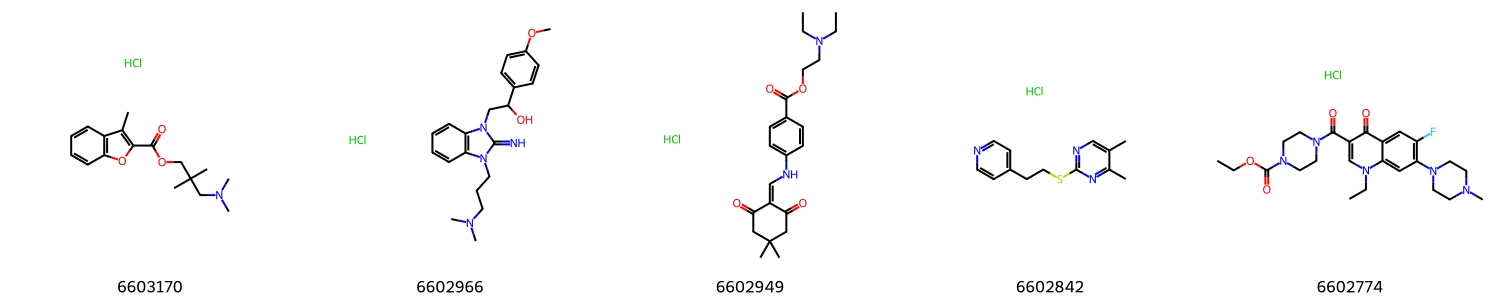

In [ ]:
mols = []
for mol in spl:
    mols.append(mol)
 
# 获取前十个分子
mols = mols[:5]
 
#输出分子结构
DrawingOptions.bondLineWidth=1.8    #键粗细
DrawingOptions.atomLabelFontSize=0.5  #名字
DrawingOptions.includeAtomNumbers=True
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), legends=[x.GetProp('_Name') for x in mols])
img

## 4、将分子以表格形式读取

### 4.1 sdf文件以表格形式读入

In [ ]:
# 设置embedProps为True可以将ROMol一列的分子带有的属性一并包含
df = PandasTools.LoadSDF('/content/drive/My Drive/data/molecules.sdf', smilesName="SMILE", embedProps=True)  
# 查看分子dataframe中列信息
df.columns
# 查看前三行，四列信息
df.iloc[:3,:4]

,PUBCHEM_COMPOUND_CID,ID,SMILE,ROMol
0,6603170,6603170,Cc1c(C(=O)OCC(C)(C)CN(C)C)oc2ccccc12.Cl,<rdkit.Chem.rdchem.Mol object at 0x7f778ffe4a50>
1,6602966,6602966,COc1ccc(C(O)Cn2c(=N)n(CCCN(C)C)c3ccccc32)cc1.Cl,<rdkit.Chem.rdchem.Mol object at 0x7f778ffe4970>
2,6602949,6602949,CCN(CC)CCOC(=O)c1ccc(NC=C2C(=O)CC(C)(C)CC2=O)c...,<rdkit.Chem.rdchem.Mol object at 0x7f778ffe4430>


In [ ]:
# 两个dataframe合并
#df1.append(df2)

### 4.2 计算分子描述符

In [ ]:
# 计算三维描述符Fsp3(表示sp3杂化碳原子所占比例),并添加到表格中
df['Fsp3'] = df.ROMol.map(Descriptors.FractionCSP3)
# 计算Morgan指纹
#df['FP'] = df.ROMol.map(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048))
df['FP'] = df.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x['ROMol'], 2, 2048), axis=1)  # map和apply将后面的函数施加给前面对象。axis=1按照列施加函数，等于0按照行施加
# 计算Tanimoto系数（用于描述分子间相似度）
df['Tanimoto'] = DataStructs.BulkTanimotoSimilarity(df.FP[0], df.FP)   # 拿第一个分子的FP做相似度比较的参照
# 计算分子量
# 给每个分子计算分子量
df['MW'] = df['ROMol'].apply(lambda x: Descriptors.MolWt(x))
df.iloc[[1,3],[2,3]] # 使用切片可以任意地删除行或列

df[['ID', 'SMILE', 'ROMol', 'Tanimoto', 'Fsp3','FP']].head(3)

,ID,SMILE,ROMol,Tanimoto,Fsp3,FP
0,6603170,Cc1c(C(=O)OCC(C)(C)CN(C)C)oc2ccccc12.Cl,<rdkit.Chem.rdchem.Mol object at 0x7f778ffe4a50>,1.000000,0.470588,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,6602966,COc1ccc(C(O)Cn2c(=N)n(CCCN(C)C)c3ccccc32)cc1.Cl,<rdkit.Chem.rdchem.Mol object at 0x7f778ffe4970>,0.175676,0.380952,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,6602949,CCN(CC)CCOC(=O)c1ccc(NC=C2C(=O)CC(C)(C)CC2=O)c...,<rdkit.Chem.rdchem.Mol object at 0x7f778ffe4430>,0.168831,0.500000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


### 4.3 使用比较运算符进行子结构搜索（匹配）

In [ ]:
# 用于匹配的子结构
Substruct = Chem.MolFromSmiles('CC(C1=CC=CC=C1)=O')
# 过滤后的dataframe
df_filter = df[df.ROMol >= Substruct]

df_filter[['SMILE','Fsp3']]
#df_filter.iloc[:2,:]

,SMILE,Fsp3
52,CC1(C)CC(=O)c2cc(OCC(=O)N3CCN(c4ccccc4F)CC3)cc...,0.391304
94,CN(C)S(=O)(=O)c1cccc(C(=O)C2=C3SC=C(c4ccccc4)N...,0.190476
167,CC(=O)c1cccc(NC(=O)Nc2cccnc2)c1,0.071429


In [ ]:
# 导出sdf  (idName指定分子名取自哪一列，proterties的属性追加到文件原子坐标后)
PandasTools.WriteSDF(df_filter, 'output.sdf', idName='ID', properties=['Fsp3','Tanimoto'])

# 导出smile
PandasTools.SaveSMILESFromFrame(df_filter, 'output.smi', NamesCol='ID')

### 4.4给dataframe添加骨架smile列

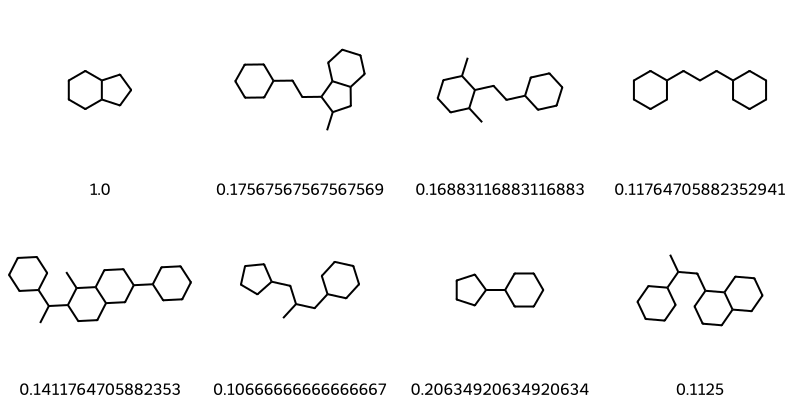

In [ ]:
PandasTools.AddMurckoToFrame(df, MurckoCol='Murcko_SMILES')
# 将杂环中的非碳原子转为碳原子得到的smile
PandasTools.AddMurckoToFrame(df, MurckoCol='Murcko_generic_SMILES', Generic=True)
# 将骨架smile转为分子结构
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_Mol', smilesCol='Murcko_SMILES')
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_generic_Mol', smilesCol='Murcko_generic_SMILES')
# 将骨架结构绘制出（标签用Tanimoto数值代替）
PandasTools.FrameToGridImage(df[:8], column='Murcko_generic_Mol', legendsCol='Tanimoto', molsPerRow=4)

### 4.5统计分子库中各类原子的数目

In [ ]:
def number_of_atoms(atom_list, df): 
    for elmt in atom_list:
      #返回结果是布尔值 
      df['num_of_{}_atoms'.format(elmt)] = df['ROMol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(elmt))))
number_of_atoms(['C','O', 'N','P', 'S'], df)
 
# Get the number of aromatic and aliphatic rings
df['num_of_arom_rings'] = df['ROMol'].apply(lambda x: rdMolDescriptors.CalcNumAromaticRings(x))
df['num_of_aliph_rings'] = df['ROMol'].apply(lambda x: rdMolDescriptors.CalcNumAliphaticRings(x))
 
# Check the columns 
df.iloc[[1,3],[-1,4]] #不连续切片
df.iloc[1:3,-3:] #连续切片

,num_of_S_atoms,num_of_arom_rings,num_of_aliph_rings
1,0,3,0
2,0,1,1


In [ ]:
print("分子中所含硫原子数目: {}".format(
    df['num_of_S_atoms'].astype(bool).sum()))
print("分子中所含磷原子数目: {}".format(
    df['num_of_P_atoms'].astype(bool).sum()))
print("分子中所含氮原子数目: {}".format(
    df['num_of_N_atoms'].astype(bool).sum()))
print("分子中所含氧原子数目: {}".format(
    df['num_of_O_atoms'].astype(bool).sum()))

分子中所含硫原子数目: 95
分子中所含磷原子数目: 2
分子中所含氮原子数目: 194
分子中所含氧原子数目: 190


## 5.生成带原子序号索引的图

In [ ]:
# 定义函数
def mol_with_atom_index(m):
    atoms = m.GetNumAtoms()
    for idx in range(atoms):
        m.GetAtomWithIdx(idx).SetProp( 'molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()) )
    return m

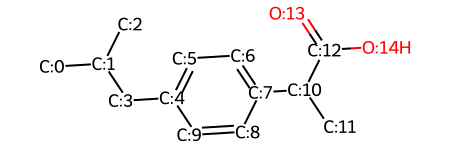

In [ ]:
mol_with_atom_index(mol)